# Final Project- Using Clustering Algorithms to understand large text corporation

## Importing the libraries

In [61]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")

## Loading the dataset

In [19]:
df = pd.read_csv("SMSSpamCollection", sep='\t', header=None, names=['label', 'text'])
df.shape

(5572, 2)

In [21]:
df.head(25)
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


## Data preprocessing and cleaning

In [24]:
stopwords = set([
    'the', 'and', 'is', 'in', 'to', 'of', 'that', 'it', 'on', 'for', 'you', 'this', 'with', 'as',
    'are', 'was', 'but', 'be', 'have', 'not', 'they', 'or', 'at', 'from', 'an', 'by', 'if', 'has',
    'so', 'we', 'can', 'my', 'all', 'me', 'do', 'no', 'will', 'just', 'your', 'about', 'what', 'would'
])

def basic_lemmatizer(word):                # for NLP
    if word.endswith("ing") or word.endswith("ed"):
        return word[:-3]
    elif word.endswith("s") and len(word) > 3:
        return word[:-1]
    return word

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)         # Remove punctuation/numbers
    tokens = text.split()
    tokens = [basic_lemmatizer(word) for word in tokens if word not in stopwords and len(word) > 2]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(preprocess_text)

## Performing some EDA to analyze better

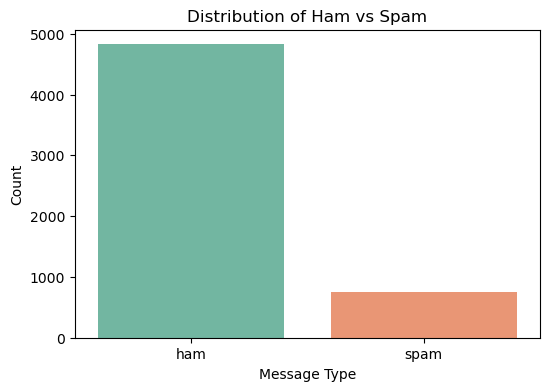

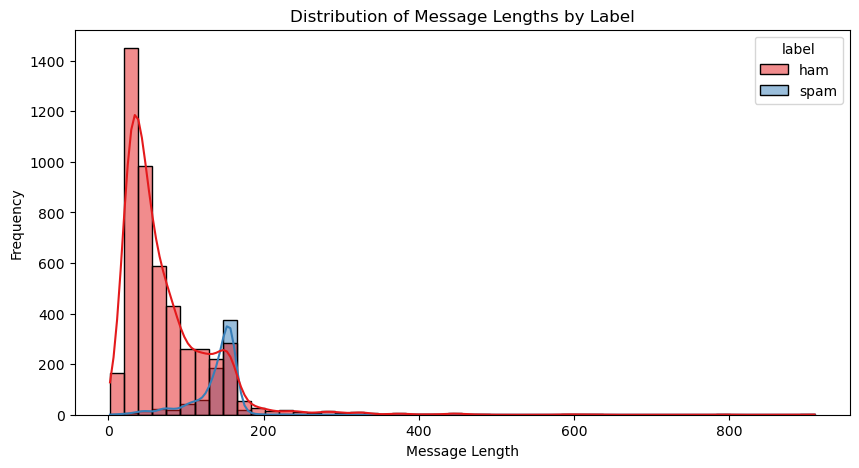

In [67]:
plt.figure(figsize=(6, 4))               # 1. Class distribution
sns.countplot(data=df, x='label', palette='Set2')
plt.title('Distribution of Ham vs Spam')
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.show()


df['length'] = df['text'].apply(len)    # 2. Message length distribution

plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='length', hue='label', bins=50, palette='Set1', kde=True)
plt.title('Distribution of Message Lengths by Label')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()

# to find most common words in ham and spam
from collections import Counter

def get_top_words(text_series, n=20):
    all_words = ' '.join(text_series).split()
    return Counter(all_words).most_common(n)

top_spam_words = get_top_words(df[df['label'] == 'spam']['clean_text'])
top_ham_words = get_top_words(df[df['label'] == 'ham']['clean_text'])

## Splitting the dataset into training and testing sets

In [70]:
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, random_state=42
)

## Feature Extraction by TF-IDF

In [72]:
tfidf = TfidfVectorizer(max_features=1000)

X_train = tfidf.fit_transform(X_train_text).toarray()
X_test = tfidf.transform(X_test_text).toarray()

## Selecting and creating model 

k=2: Silhouette Score=0.0067, Inertia=4306.94
k=3: Silhouette Score=0.0098, Inertia=4269.46
k=4: Silhouette Score=0.0097, Inertia=4257.23
k=5: Silhouette Score=0.0095, Inertia=4234.37
k=6: Silhouette Score=0.0108, Inertia=4215.77
k=7: Silhouette Score=0.0121, Inertia=4196.95
k=8: Silhouette Score=0.0126, Inertia=4176.14
k=9: Silhouette Score=0.0146, Inertia=4157.56
k=10: Silhouette Score=0.0160, Inertia=4142.21


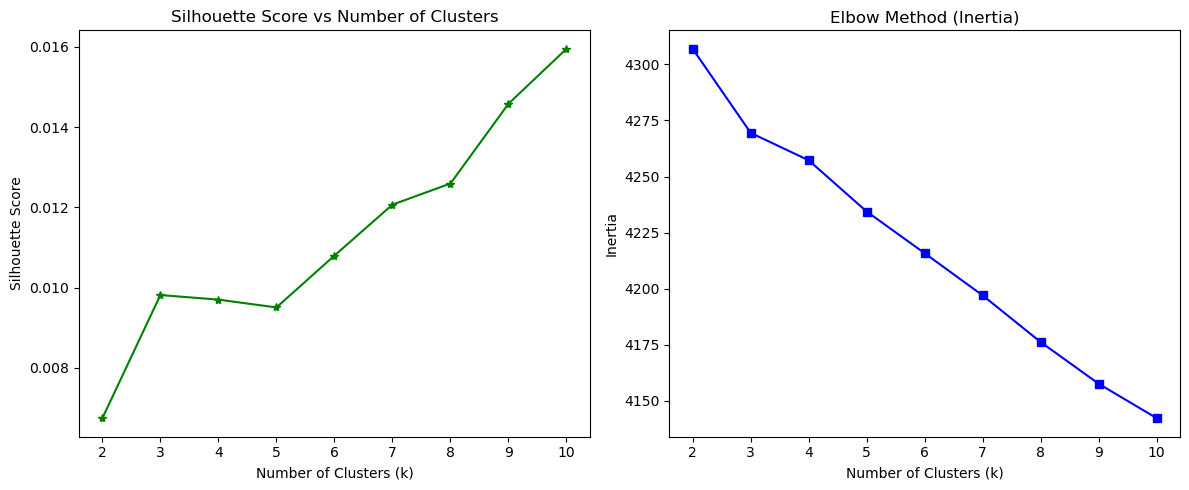

In [74]:
sil_scores = []
inertias = []
k_range = range(2, 11)    # to find appropriate value of k in K-means by silhouette scores 

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_train)
    sil = silhouette_score(X_train, labels)
    sil_scores.append(sil)
    inertias.append(kmeans.inertia_)
    print(f"k={k}: Silhouette Score={sil:.4f}, Inertia={kmeans.inertia_:.2f}")

plt.figure(figsize=(12, 5))

# Silhouette Score for hyperparameter tuning the value of k
plt.subplot(1, 2, 1)
plt.plot(k_range, sil_scores, marker='*', color='green')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")

# Elbow Method - Inertia
plt.subplot(1, 2, 2)
plt.plot(k_range, inertias, marker='s', color='blue')
plt.title("Elbow Method (Inertia)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")

plt.tight_layout()
plt.show()

In [76]:
k=3  ## most optimal value as per elbow method
kmeans1 = KMeans(n_clusters=k, random_state=42)
train_clusters = kmeans1.fit_predict(X_train)
test_clusters = kmeans1.predict(X_test)


## Evaluation of Clusters to true lables

In [82]:
test_result_df = pd.DataFrame({         # Comparing predicted clusters to real labels in test set
    'true_label': y_test.values,
    'cluster': test_clusters
})

# Crosstab to understand cluster distribution by class
cluster_summary = pd.crosstab(test_result_df['cluster'], test_result_df['true_label'])
print(cluster_summary)

true_label  ham  spam
cluster              
0            32     2
1           899    80
2            35    67


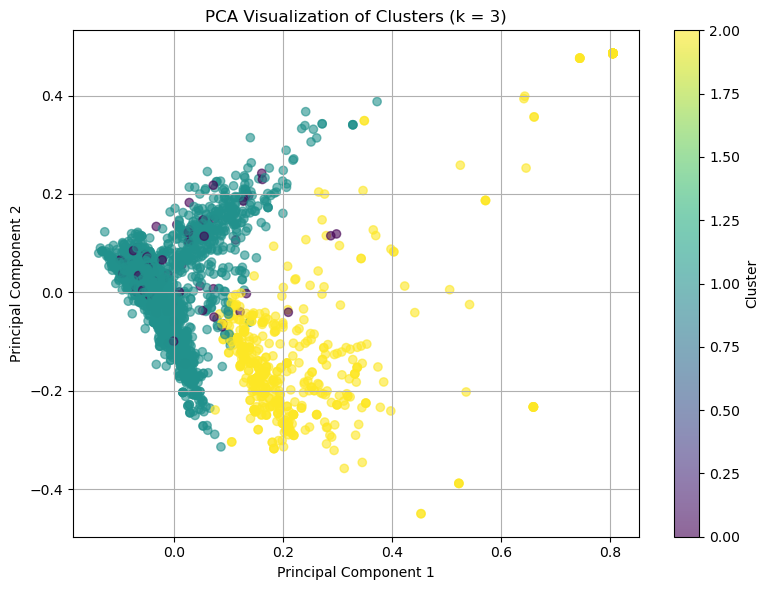

In [78]:
from sklearn.decomposition import PCA

X_combined = tfidf.transform(df['clean_text']).toarray()
all_clusters = kmeans1.predict(X_combined)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_combined)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=all_clusters, cmap='viridis', alpha=0.6)
plt.title(f'PCA Visualization of Clusters (k = 3)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

In [84]:
df['cluster'] = all_clusters
final_df = df[['label', 'text', 'clean_text', 'cluster']]

# Exporting to CSV
final_df.to_csv("sms_cluster_results.csv", index=False)

print("Clustered results exported to 'sms_cluster_results.csv'")


Clustered results exported to 'sms_cluster_results.csv'
